## Нейросети - основы.
### Ноутбук составлен по воспоминаниям из разных курсов, в первую очередь Stanford cs231n, Jeremy Howard Fast AI, а также по материалам с сайта Eli Bendersky https://eli.thegreenplace.net/

В первой части ноутбука реализован простейший нейрон, который повторяет логистическую регрессию. Проверяется, как он будет обучаться с помощью метода градиентного спуска и стохастического градиентного спуска. 

Во второй части ноутбука с помощью numpy реализуется полноценная нейросеть, поддерживающая механизм backpropagation как метод класса. Нейросеть может включать в себя линейный слой, Sigmoid, Relu, LeakyRelu, Tanh, Softmax и использовать Binary Cross-Entropy Loss, BCEWithLogitsLoss, Cross-Entropy Loss. Демонстрируется влияние BCEWithLogitsLoss на стабильность обучения по сравнению с Binary Cross-Entropy Loss.

### Часть 1. Простейший классификатор на основе одного нейрона. Градиентный спуск

Попробуем сделать простейший нейрон. n входов, 1 выход, от n входов сигнал передается с весами w, в самом нейроне действует функция активации, работающая с суммой сигналов от входов. Для начала воспользуемся классической сигмоидой, чтобы воспроизвести логистическую регрессию. 

В первой части реализуем все без numpy, numpy будем использовать только для функции plot_decision_regions, так как она на входе требует ndarray.

In [1]:
import math

In [2]:
def sigm(x):
    return 1 / (1 + math.exp(-x))

In [3]:
import matplotlib.pyplot as plt

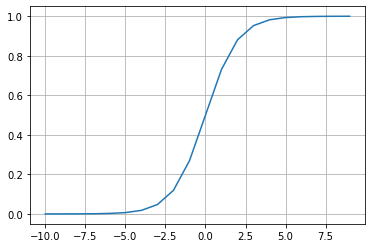

In [4]:
X = [x for x in range(-10, 10)]
Y = [sigm(x) for x in X]
plt.plot(X, Y)
plt.grid()
plt.show()

In [5]:
class Neuron:
    
    def __init__(self, n, activation):
        self.w = [0.5 for i in range(n)] # будем пока пользоваться статической инициализацией весов
        self.act = activation
        
    def forward(self, X):
        result = 0
        for x, w in zip(X, self.w):
            result += x * w
        return self.act(result)

Пусть будет 2 признака, подаваемых на вход нейрона

In [6]:
X1 = [-4, 4]
X2 = [1, 2]
X3 = [-1, -2]
N1 = Neuron(2, sigm)
print(N1.forward(X1), N1.forward(X2), N1.forward(X3))
print(1 / (1 + math.exp(0)), 1 / (1 + math.exp(-1.5)), 1 / (1 + math.exp(1.5)))

0.5 0.8175744761936437 0.18242552380635635
0.5 0.8175744761936437 0.18242552380635635


В направлении forward работает. Теперь нейрон нужно обучить. 
Возьмем задачу классификации и логистическую функци потерь:

In [7]:
def logloss(y, y_hat):
    eps = 1e-10
    return -y * math.log(y_hat + eps, 2) - (1 - y) * math.log(1 - y_hat + eps, 2)

Создадим выборки

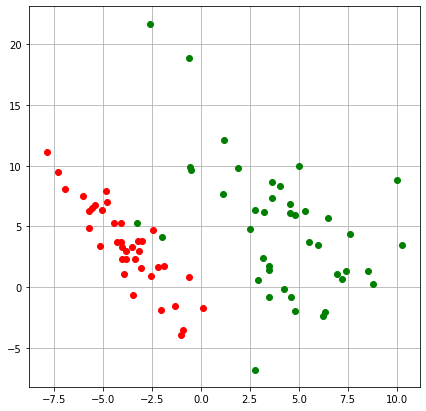

In [8]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

X, Y = make_classification(n_samples = 100, n_features = 2, 
                           n_informative = 2, n_classes = 2, 
                           n_redundant = 0,
                           n_clusters_per_class = 1,
                           scale = 4,
                           random_state = 2)

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=20, random_state = 42)

fig = plt.figure(figsize=(7, 7))

plt.plot(train_X[np.where(train_Y==0), 0], train_X[np.where(train_Y==0), 1], 'ro')
plt.plot(train_X[np.where(train_Y==1), 0], train_X[np.where(train_Y==1), 1], 'go')
plt.grid()

plt.show()

Посмотрим, как выглядит зависимость эмпирического риска от весов нейрона. Будет интересно отследить, как будет меняться эмпирический риск модели в процессе обучения.

In [9]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [10]:
def makeData(X_train, Y_train):
    W1 = np.arange (-20, 20, 0.4)
    W2 = np.arange (-20, 20, 0.4)
    w1grid, w2grid = np.meshgrid(W1, W2)
    
    lossgrid = np.zeros((len(W1), len(W2)))
    for i, w1 in enumerate(W1):
        for j, w2 in enumerate(W2):
            N = Neuron(2, sigm)
            N.w = [w1, w2]
            result = []
            for x, y in zip(X_train, Y_train):
                y_hat = N.forward(x)
                result.append(logloss(y, y_hat))
            lossgrid[j, i] = sum(result) / len(result)

    return w1grid, w2grid, lossgrid

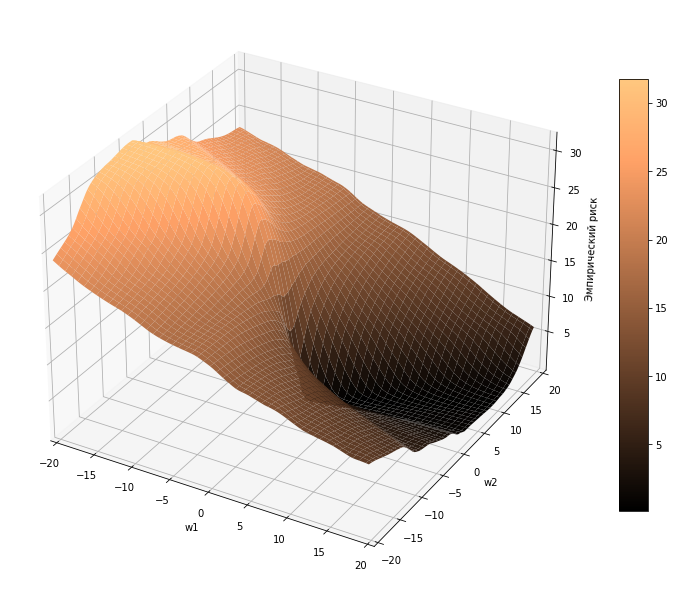

In [11]:
x, y, U = makeData(train_X, train_Y)
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(axes)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_zlabel('Эмпирический риск')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.copper)
fig.colorbar(surf, shrink=0.5, aspect=15)
pylab.show()

Необходимо подобрать веса w1 и w2 так, чтобы минимизировать функцию ошибки. Если мы инициализируем веса любыми значениями, отличными от оптимальных, необходимо изменять их таким образом, чтобы значение функции ошибки на обучающей выборке снижалось. Оптимальным изменением весов с целью снижения значения функции будет снижение в направлении, противоположном градиенту функции в рассматриваемой точке. 

Градиент - это вектор-функция, координатами которой являются частные производные. Почему вектор? Потому, что имеет координаты - по числу переменных. Почему функция? Потому, что эти координаты зависят от переменных. Градиент функции потерь, представленной на трехмерном графике выше, - это вектор в плоскости (w1, w2).

#### $$ gradL(w_1, w_2) = \left( \frac{\partial(L(w_1, w_2))}{\partial(w_1)}, \frac{\partial(L(w_1, w_2))}{\partial(w_2)} \right) $$
Частные производные показывают скорость роста функции по направлению соответствующей оси. Быстрее всего функция в точке растет в направлении своего градиента. Соответственно, чтобы добиться наискорейшего снижения значения функции, необходимо двигаться в направлении антиградиента. Как это сделать? Найти частные производные функции потерь по w1 и w2 и двигаться в пространстве (w1, w2) в противоположном этим частным производным направлении шагами определенной величины (learning rate). Это и есть метод градиентного спуска.

Проблема в том, что функция потерь зависит не только от w1 и w2, но и от обучающей выборки. Если бы зависимость от каких-либо переменных, кроме w1 и w2, отсутствовала, мы могли бы аналитически вычислять значение градиента в каждой точке. Или вообще нашли бы значение минимума функции по w1 и w2, приравняв к нулю частные производные. Вместо этого частные производные по переменным придется вычислять, рассчитывая значение функции потерь по обучающей выборке в каждой интересующей нас точке. 

#### $$ logloss(y, \hat y(X, W)) =  -ylog_2(\hat y(X, W)) - (1-y)(log_2(1-\hat y(X, W))) = $$
#### $$ = -ylog_2(\frac{1}{1+e^{-(x_1w_1 + x_2w_2)}}) - (1-y)log_2(1- \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}})$$

Частные производные функции потерь по w1 и w2 равны:
#### $$\frac{\partial logloss(y, \hat y(X, W))}{\partial w_1} = \frac{x_1}{ln2}\left( \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}} - y\right)$$
#### $$\frac{\partial logloss(y, \hat y(X, W))}{\partial w_2} = \frac{x_2}{ln2}\left( \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}} - y\right)$$
В скобках - разность между выходом нейрона и действительным значением зависимой переменной.

Реализуем метод градиентного спуска, пока не стохастический. Формально правило для изменения весов запишется так:
#### $$w:=w - \eta \nabla Q(w) = w - \frac{\eta}{n}\sum_{i=1}^n{\nabla Q_i(w)} $$
, где w - искомый вектор параметров модели, минимизирующий эмпирический риск, сумма берется по всем элементам обучающей выборки. 
Так как w - это вектор, градиенты по обучающей выборке на каждом шаге необходимо накапливать отдельно для каждого компонента вектора (переменные w0_sum и w1_sum в алгоритме ниже). 

In [12]:
def gDescent(X_train, Y_train, N1, lr = 0.1, criterion = 0.01, max_iter = 100, debug = 0):
    
    """ Градиентный спуск для одного нейрона с двумя весами. 
    
    
    Эмпирический риск считается на каждом шаге и сохраняется наряду с текущими весами модели, 
    чтобы можно было отследить изменение суммы значений функции потерь на трехмерном графике.
    
    Аргументы: 
    X_train, Y_train -- элементы и ответы обучающей выборки
    N1 -- нейрон, который необходимо обучить. В этой простейшей функции реализация для двух признаков.
    lr -- learning rate
    criterion -- критерий остановки, усредненное значение эмпирического риска, при которой модель считается обученной
    max_iter -- критерий остановки. Максимальное количество циклов обучения
    debug -- уровень логгирования. 
    
    Возвращает списки с весами w1 и w2, содержащими значения весов на каждом шаге обучения, а также
    список lossfunc, содержащий значения эмпирического риска на каждом шаге обучения
    """
    curr_loss = 1e3
    iteration = 0
    w0s = []
    w1s = []
    lossfunc = []
    
    while curr_loss > criterion and iteration < max_iter:
        
        losses = []
        Y_hat = []
        w1_sum = w2_sum = 0
        
        # В нестохастической версии градиентного спуска на каждой итерации градиент рассчитывается по всей выборке
        for x, y in zip(X_train, Y_train):
            y_hat = N1.forward(x)
            Y_hat.append(y_hat)
            losses.append(logloss(y, y_hat))
            w1_sum += x[0] / math.log(2) * (y_hat - y)
            w2_sum += x[1] / math.log(2) * (y_hat - y)
            
        curr_loss = sum(losses) / len(losses)
        acc = accuracy(Y_train, Y_hat)
        w0s.append(N1.w[0])
        w1s.append(N1.w[1])
        lossfunc.append(curr_loss)
        
        period = math.ceil(max_iter / 30)
        if debug and iteration % period == 0: print(f'iteration {iteration}, curr_loss = {curr_loss}, accuracy = {acc}')
        
        N1.w[0] += (-1) * lr * 1 / len(Y_train) * w1_sum # домножаем на -1, так как для поиска минимума мы должны двигаться в направлении, противоположном градиенту
        N1.w[1] += (-1) * lr * 1 / len(Y_train) * w2_sum # домножаем на -1, так как для поиска минимума мы должны двигаться в направлении, противоположном градиенту
        if debug == 2: print(f'new weights: {N1.w}')
        iteration += 1
    return w0s, w1s, lossfunc

In [13]:
def accuracy(Y, Y_hat):
    errors = 0
    for y, y_hat in zip(Y, Y_hat):
        if round(y_hat) != y:
            errors += 1
    return (len(Y) - errors) / len(Y)

Зададим стартовые веса нейрона намеренно в области с высоким эмпирическим риском, чтобы посмотреть, как сеть будет обучаться на большом диапазоне W

In [14]:
N1 = Neuron(2, sigm)
N1.w = [-20, -2]
w0s, w1s, lossfunc = gDescent(train_X, train_Y, N1, lr = 0.03, max_iter = 200, debug = 1)

iteration 0, curr_loss = 30.856196945638516, accuracy = 0.0375
iteration 7, curr_loss = 30.797442133876103, accuracy = 0.0375
iteration 14, curr_loss = 30.70797171844036, accuracy = 0.0375
iteration 21, curr_loss = 30.58502123782521, accuracy = 0.0375
iteration 28, curr_loss = 30.431470647287746, accuracy = 0.0375
iteration 35, curr_loss = 30.254964580820427, accuracy = 0.0375
iteration 42, curr_loss = 30.04809326125376, accuracy = 0.0375
iteration 49, curr_loss = 29.78517196591161, accuracy = 0.0375
iteration 56, curr_loss = 29.42172811639755, accuracy = 0.0375
iteration 63, curr_loss = 28.93528350961041, accuracy = 0.0375
iteration 70, curr_loss = 28.270652248499665, accuracy = 0.05
iteration 77, curr_loss = 27.18387088359438, accuracy = 0.05
iteration 84, curr_loss = 25.20400815673619, accuracy = 0.0625
iteration 91, curr_loss = 21.883867691307948, accuracy = 0.075
iteration 98, curr_loss = 16.783537047206874, accuracy = 0.075
iteration 105, curr_loss = 10.071312003868297, accuracy 

Создадим примитивный классификатор на основе одного нейрона, в котором реализован метод predict. Он потребуется, чтобы подать его на вход функции plot_decision_regions.

In [15]:
class PrimitiveNN:
    
    def __init__(self, Neuron):
        self.N = Neuron
        
    def predict(self, X_test):
        result = []
        for x in X_test:
            result.append(round(self.N.forward(x)))
        return np.array(result)

primNN = PrimitiveNN(N1)

Один нейрон строит разделяющую поверхность в виде прямой:

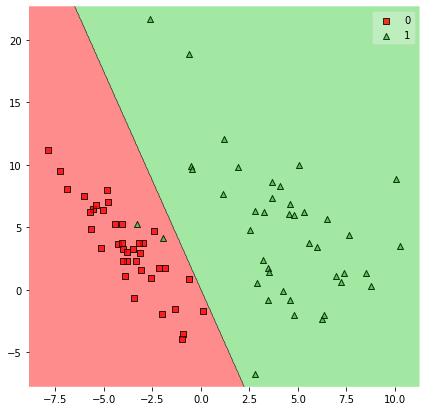

In [16]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, primNN, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Посмотрим, как менялось значение эмпирического риска на каждом шаге обучения

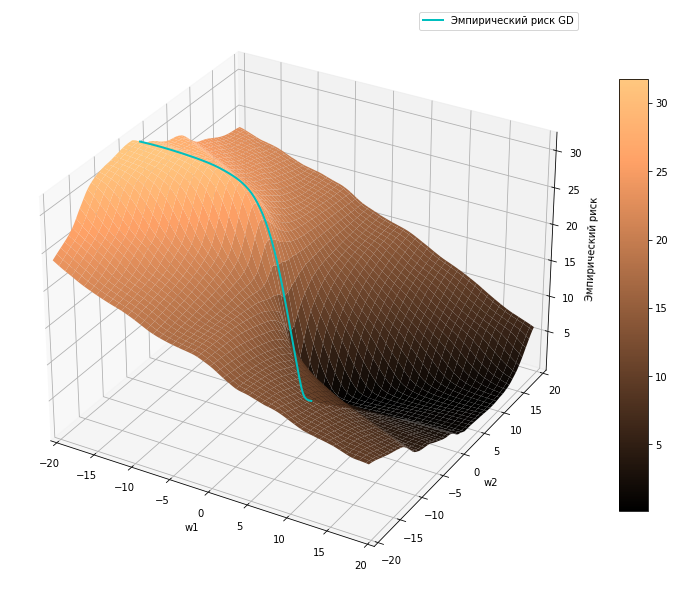

In [17]:
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(axes)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_zlabel('Эмпирический риск')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.copper)
fig.colorbar(surf, shrink=0.5, aspect=15)
axes.plot(np.array(w0s), np.array(w1s), np.array(lossfunc), label='Эмпирический риск GD', color = 'c', linewidth=2, zorder = 10)
axes.legend()
pylab.show()

По графику видно, что из точки с наибольшим эмпирическим риском параметры модели успешно модифицируются и по кратчайшему пути следуют в область минимума функции.

Реализуем стохастический градиентный спуск. Вместо того, чтобы рассчитывать градиентный шаг, суммируя градиенты по всем экземплярам обучающей выборки, будем случайным образом брать несколько экземпляров обучающей выборки и считать градиентный шаг только по ним. Это позволит ускорить обучение, особенно на больших обучающих выборках.

Для более корректного отображения эмпирического риска на графике, а также чтобы более честно считать accuracy, будем на каждой итерации пересчитывать точность и эмпирический риск по всей обучающей выборке. Градиентный шаг при этом будем рассчитывать, опираясь только на mibi_batch.

In [18]:
import random

def SGD(X_train, Y_train, N1, lr = 0.1, criterion = 0.01, max_iter = 100, batch_size = 8, debug = 0):
    
    """ Стохастический градиентный спуск для одного нейрона с двумя весами. 
    
    
    Эмпирический риск считается на каждом шаге по всей обучающей выборке и сохраняется наряду с текущими весами модели, 
    чтобы можно было отследить изменение суммы значений функции потерь на трехмерном графике.
    
    Аргументы: 
    X_train, Y_train -- элементы и ответы обучающей выборки
    N1 -- нейрон, который необходимо обучить. В этой простейшей функции реализация для двух признаков.
    lr -- learning rate
    criterion -- критерий остановки, усредненное значение эмпирического риска, при которой модель считается обученной
    max_iter -- критерий остановки. Максимальное количество циклов обучения
    batch_size -- количество экземпляров обучающей выборки, используемое для расчета градиента на одной итерации
    debug -- уровень логгирования. 
    
    Возвращает списки с весами w1 и w2, содержащими значения весов на каждом шаге обучения, а также
    список lossfunc, содержащий значения эмпирического риска на каждом шаге обучения
    """
    
    curr_loss = 1e3
    iteration = 0
    w0s = []
    w1s = []
    lossfunc = []
    while curr_loss > criterion and iteration < max_iter:
        
        losses = []
        Y_hat = []
        
        for x, y in zip(X_train, Y_train):
            y_hat = N1.forward(x)
            Y_hat.append(y_hat)
            losses.append(logloss(y, y_hat))
            
        curr_loss = sum(losses) / len(losses)
        acc = accuracy(Y_train, Y_hat)
        w0s.append(N1.w[0])
        w1s.append(N1.w[1])
        lossfunc.append(curr_loss)
        
        period = math.ceil(max_iter / 30)
        if debug and iteration % period == 0: print(f'iteration {iteration}, curr_loss = {curr_loss}, accuracy = {acc}')
        
        batch_index = random.sample([i for i in range(len(Y_train))], batch_size)
        w1_sum = w2_sum = 0
        for x, y in zip(X_train[batch_index], Y_train[batch_index]):
            y_hat = N1.forward(x)
            w1_sum += x[0] / math.log(2) * (y_hat - y)
            w2_sum += x[1] / math.log(2) * (y_hat - y)
        
        N1.w[0] += (-1) * lr * 1 / len(batch_index) * w1_sum
        N1.w[1] += (-1) * lr * 1 / len(batch_index) * w2_sum
        if debug == 2: print(f'gradients = {w1_sum, w2_sum}, new weights: {N1.w}')
        
        iteration += 1
    return w0s, w1s, lossfunc

Аналогично, инициализируем веса в области высокого эмпирического риска, чтобы нагляднее видеть процесс обучения

In [19]:
N2 = Neuron(2, sigm)
N2.w = [-20, -2]
w0s, w1s, lossfunc = SGD(train_X, train_Y, N2, lr = 0.03, max_iter = 200, debug = 1)

iteration 0, curr_loss = 30.856196945638516, accuracy = 0.0375
iteration 7, curr_loss = 30.71381000413816, accuracy = 0.0375
iteration 14, curr_loss = 30.420359443667387, accuracy = 0.0375
iteration 21, curr_loss = 30.379535236588964, accuracy = 0.0375
iteration 28, curr_loss = 30.126924908152507, accuracy = 0.05
iteration 35, curr_loss = 29.881414534415786, accuracy = 0.05
iteration 42, curr_loss = 29.415456059737302, accuracy = 0.0875
iteration 49, curr_loss = 29.419576146548565, accuracy = 0.075
iteration 56, curr_loss = 29.076633263104895, accuracy = 0.075
iteration 63, curr_loss = 28.67441448670749, accuracy = 0.075
iteration 70, curr_loss = 28.15150451435439, accuracy = 0.0875
iteration 77, curr_loss = 27.264580091869714, accuracy = 0.0875
iteration 84, curr_loss = 25.56349938115649, accuracy = 0.0875
iteration 91, curr_loss = 22.78108300480775, accuracy = 0.0875
iteration 98, curr_loss = 18.01416902425689, accuracy = 0.0875
iteration 105, curr_loss = 11.431439410475647, accuracy

Разделяющая поверхность построена успешно:

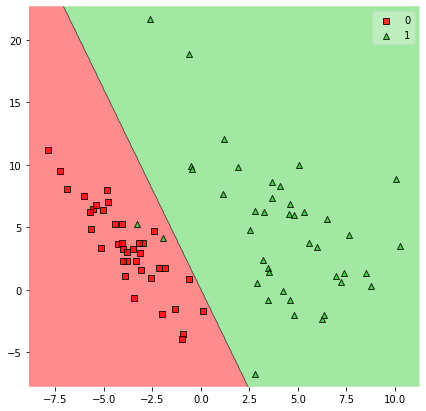

In [20]:
primNN2 = PrimitiveNN(N2)
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, primNN2, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

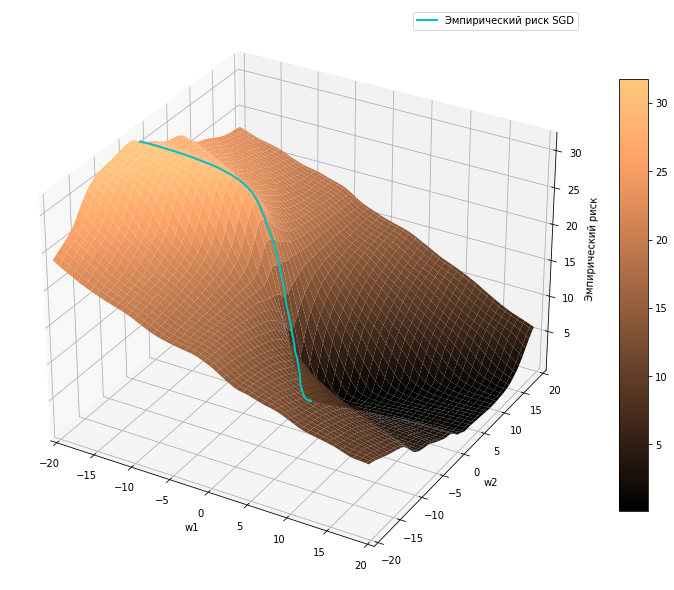

In [21]:
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(axes)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_zlabel('Эмпирический риск')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.copper)
fig.colorbar(surf, shrink=0.5, aspect=15)
axes.plot(np.array(w0s), np.array(w1s), np.array(lossfunc), label='Эмпирический риск SGD', color = 'c', linewidth=2, zorder = 10)
axes.legend()
pylab.show()

Видно, что несмотря на то, что в SGD используется batch размером в 8 экземпляров вместо полного обучающего датасета длиной 80, сходимость обоих алгоритмов практически одинаковая - уровень эмпирического риска меньше 1.0 достигается в обоих случаях между 112 и 119 шагами при идентичной lr = 0.03. По графику SGD видно, что он чуть менее гладкий, но спуск идет по той же траектории в тот же минимум.

### Часть 2. Метод обратного распространения ошибки

Реализуем теперь нейросеть на основе Fully Connected Layers и нелинейных функций активации с помощью numpy. Нейросеть нужно будет делать из компонент - слоев, чтобы можно было последовательно через эти слои запустить forward pass и backward pass. 

Forward pass аналогичен реализованному выше механизму получения выходного сигнала с единичного нейрона: на вход слоя подается входной сигнал, слой выполняет требуемые преобразования и отдает выходной сигнал, который далее обрабатывается следующим слоем или выдает результат классификации/регрессии, на основе которого рассчитывается ошибка. 

Концепция backward pass сложнее. Для обучения нейросети методом градиентного спуска необходимо уметь рассчитывать частные производные от функции потерь по каждому параметру сети, чтобы выполнить градиентный шаг. Производные по параметрам можно получить аналитически, но для крупной нейросети аналитический расчет будет недопустимо сложным. Альтернативным методом вычисления градиентов является механизм обратного распространения ошибки backpropagation, основанный на т.н. chain rule, или правиле взятия производной сложной функции: 

#### $$\frac{\partial f(y(x))}{\partial x} = \frac{\partial f(y)}{\partial y(x)}\frac{\partial y(x)}{\partial x}$$

При проходе forward pass каждый последующий слой нейросети принимает на вход сигнал от предыдущего слоя, выполняет преобразование в соответствии со своей логикой и передает выходной сигнал дальше по сети. Соответственно, частную производную по какому-либо параметру в текущем слое можно рассчитать через произведение "входящего" градиента (частная производная функции потерь по выходу из рассматриваемого слоя) и градиента функции в рассматриваемом слое по искомому параметру.

При прохождении backward pass кроме частных производных по параметрам рассматриваемого слоя необходимо рассчитывать частные производные по входам с предыдущего (лежащего ближе к входам сети) уровня. Именно эти производные станут "входящими" для расчета градиентов на предыдущем уровне. 

Релизуем линейный слой (Fully Connected Layer) с учетом описанной логики. Пусть на вход линейного слоя подается batch размером N, каждый экземпляр выборки представлен D-признаками. Пусть выход линейного слоя представлен M - нейронами. Тогда на выходе слоя будем получать batch размером N x M. Соответственно, веса линейного слоя образуют матрицу W размерностью (D x M)

В рамках механизма backpropagation необходимо рассчитать два вида градиентов:
#### $$ \frac{\partial L(X, W)}{\partial W} $$
для расчета градиентного шага и 
#### $$ \frac{\partial L(X, W)}{\partial X} $$
для передачи градиентов на предыдущий слой

Для расчета обеих матриц необходимо знать входящий градиент, поступающий от уровня, находящегося "ближе" к выходу из нейросети, т.е., производную функции потерь по выходу из рассматриваемого слоя. Обозначим выход из нашего линейного слоя Y, его размерность будет N x M. Так как значение функции потерь - это скаляр, его производная по матрице Y будет иметь ту же размерность, что и сама матрица Y. То есть, на вход нашего линейного слоя в рамках механизма backpropagation мы должны получить матрицу
#### $$ \frac{\partial L}{\partial Y} = \begin{pmatrix} \frac{\partial L}{\partial y_{1,1}}&. . .&\frac{\partial L}{\partial y_{1,M}}\\\frac{\partial L}{\partial y_{N,1}}&. . .& \frac{\partial L}{\partial y_{N,M}}\end{pmatrix}$$

Дальше, пользуясь chain rule, получим

#### $$\frac{\partial L(X, W)}{\partial W} = \frac{\partial L(X, W)}{\partial Y}\frac{\partial Y}{\partial W} $$
#### $$\frac{\partial L(X, W)}{\partial X} = \frac{\partial L(X, W)}{\partial Y}\frac{\partial Y}{\partial X} $$
где $\frac{\partial Y}{\partial W}$ и $\frac{\partial Y}{\partial X}$ - Якобианы, содержащие частные производные каждого компонента матрицы Y по каждому компоненту матриц X и W соответственно.

С Якобианами в общем виде работать непрактично ввиду их разреженности и большого размера, поэтому (здесь без вывода) для частных производных по X и по W линейного слоя используются готовые формулы:
#### $$\frac{\partial L(X, W)}{\partial W} = X^T\frac{\partial L(X, W)}{\partial Y}$$
#### $$\frac{\partial L(X, W)}{\partial X} = \frac{\partial L(X, W)}{\partial Y}W^T$$

Необходимо также отметить, что значения градиентов в формуле для весов следует делить на размер batch size. В противном случае с ростом batch size будут пропорционально расти градиенты, что потребует изменения lr для получения ожидаемых результатов при изменении batch size

In [22]:
class Linear:
    """Fully Connected Layer. 
    
    
    Параметры инициализатора:
    inp -- количество входящих нейронов
    out -- количество исходящих нейронов
    
    Инициализация весов подсмотрена в pytorch
    
    Параметры forward():
    X -- матрица размерности (N, inp), где N - размер batch
    
    Парметры backward():
    upstr_grad -- входящие градиенты со следующего уровня
    lr -- learning rate
    debug -- уровень логгирования. Выставление debug == 2 приведет к выводу градиентов на каждом шаге обучения
    """
    
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out
        stdv = 1.0 / np.sqrt(inp)
        self.W = np.random.default_rng().uniform(-stdv, stdv, (inp, out)).astype(np.float32)
        self.X_ = None # кэш для хранения входов с предыдущего уровня для расчета градиентов на backward pass
        
    def forward(self, X):
        self.X_ = X.astype(np.float32)
        return np.dot(X.astype(np.float32), self.W)
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0): 
        # реализация, не учитывающая, что с ростом batch_size градиенты будут расти пропорционально
        # delta_W = np.dot(np.transpose(self.X_), upstr_grad.astype(np.float32))
        
        # градиенты усредняются по batch size, чтобы рост batch_size не приводил к пропорциональному росту градиентов
        delta_W = np.dot(np.transpose(self.X_), upstr_grad.astype(np.float32)) / self.X_.shape[0]
        
        self.W += (-1) * lr * delta_W # домножаем на -1, так как необходимо идти в противоположную от градиента сторону
        if debug == 2: print(f'Linear Layer: W gradients = {delta_W}')
        if debug == 2: print(f'Linear Layer: new weights = {self.W}')
        return np.dot(upstr_grad.astype(np.float32), np.transpose(self.W))

In [23]:
class Sigmoid:
    
    """Сигмоида или логистическая функция
    
    Параметры lr и debug - заглушки, чтобы из класса Network можно было циклически вызывать backward для 
    всех слоев с одним и тем же набором параметров. 
    """
    
    def __init__(self):
        self.out = None
    
    def forward(self, X):
        self.out = 1 / (1 + np.exp(-X))
        return self.out
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * self.out * (1 - self.out)

In [24]:
class Network:
    """Реализация нейросети с методом predict, чтобы экземпляры класса можно было использовать в plot_decision_regions.
    
    
    Параметры инициализатора:
    layers -- список экземпляров классов слоев нейросети
    
    Параметры forward():
    X -- матрица размерности (N, D), где N - размер batch, D - количество признаков экземпляра выборки
    
    Парметры backward():
    upstr_grad -- входящие градиенты со следующего уровня
    lr -- learning rate
    debug -- уровень логгирования.
    """
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = np.round(self.forward(X))
        return Y_hat

In [25]:
def BCELoss(Y_true, Y_hat):
    """ Функция потерь Бинарная перекрестная кросс-энтропия (Binary Cross-Entropy Loss)
    
    Параметры:
    Y_true -- ответы обучающей выборки. Матрица размерностью (N, 1), где N - размер batch, значение - идентификатор класса 0 или 1
    Y_hat -- ответы модели. Матрица размерностью (N, 1), где N - размер batch, значение - вероятность класса в интервале [0, 1]
    
    Возвращает усредненное по batch значение потерь, а также вектор градиента размерностью (N, 1) для использования в backpropagation
    """
    
    eps = 1e-10
    Y_true = np.reshape(Y_true, (-1, 1))
    loss = -Y_true * np.log2(Y_hat + eps) - (1 - Y_true) * np.log2(1 - Y_hat + eps)
    grad = (Y_hat - Y_true) / (np.log(2) * Y_hat * (1 - Y_hat) + eps)
    
    # во избежание переполнения экспонент далее по backpropagation будем выполнять ограничение величины градиента
    grad = np.where(grad > 100, 100, grad)
    return loss.mean(), grad

In [26]:
def train_network(Net, X_train, Y_train, batch_size = 8, lr = 1, criterion = 0.01, max_iter = 50, debug = 0):
    """ Функция для тренировки нейросети
    
    Параметры:
    
    Net -- экземпляр класса Network
    X_train, Y_train -- экземпляры и ответы обучающей выборки
    batch_size -- количество экземпляров обучающей выборки, подаваемое на вход нейросети за 1 шаг обучения
    lr -- learning rate
    criterion -- критерий остановки - значение функции потерь на всем обучающем датасете
    max_iter -- критерий остановки - количество итераций обучения. 
    debug -- уровень логгирования
    """
    
    loss = 1e3
    iteration = 0
    
    while loss > criterion and iteration < max_iter:    
        Y_hat = Net.forward(X_train)
        loss, _ = BCELoss(Y_train, Y_hat)
        acc = (np.where(np.reshape(Y_train, Y_hat.shape) == np.round(Y_hat))[0].shape[0])/len(Y_train)
        
        period = math.ceil(max_iter / 30)
        if debug and iteration % period == 0: print(f'iteration {iteration}, loss = {loss}, accuracy = {acc}')
        
        random.seed = 42
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = BCELoss(Y_train[batch_index], Y_hat)
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

Воссоздадим единичный нейрон - логистическую регрессию с помощью нового инструментария и проверим, будет ли отличаться процесс обучения. Два входных канала, один выход их суммы через веса на Sigmoid, инициализация весов в области высокого значения эмпирического риска:

In [27]:
NN = Network([Linear(2, 1), Sigmoid()])
NN.layers[0].W = np.array([[-20.0, ], [-2.0, ]])
train_network(NN, train_X, train_Y, lr = 0.03, max_iter = 200, debug = 1)

iteration 0, loss = 30.85619694703031, accuracy = 0.0375
iteration 7, loss = 30.825647300131124, accuracy = 0.0375
iteration 14, loss = 30.815214741899638, accuracy = 0.0375
iteration 21, loss = 30.754447153304294, accuracy = 0.0375
iteration 28, loss = 30.7115184501777, accuracy = 0.0375
iteration 35, loss = 30.522322221776307, accuracy = 0.0375
iteration 42, loss = 30.40632065889206, accuracy = 0.05
iteration 49, loss = 30.33719298829906, accuracy = 0.05
iteration 56, loss = 30.186987882307086, accuracy = 0.075
iteration 63, loss = 30.12319346190207, accuracy = 0.075
iteration 70, loss = 30.080729395446987, accuracy = 0.075
iteration 77, loss = 30.08065747396313, accuracy = 0.075
iteration 84, loss = 30.056497798196688, accuracy = 0.0875
iteration 91, loss = 30.0550867189545, accuracy = 0.0875
iteration 98, loss = 30.054670169316672, accuracy = 0.0875
iteration 105, loss = 30.04699021702199, accuracy = 0.0875
iteration 112, loss = 30.043308024661478, accuracy = 0.0875
iteration 119, 

Видно, что при аналогичных параметрах (batch_size = 8, lr = 0.03) на том же самом датасете такой же нейрон обучается гораздо медленнее. Разница, по всей видимости, в том, что в SGD значения для градиентов высчитывались аналитически, а в текущей реализации они считаются методом backpropagation, причем сначала градиенты считаются для функции BCELoss, а затем проходят через сигмоиду, которая может вызывать такое явление как vanishing gradient или исчезающие градиенты.

Проверим это предположение, реализовав функцию потерь Binary Cross-Entropy With Logits Loss, которая на входе ожидает не вероятности (выходные значения с сигмоиды), а выходы из линейного слоя, т.н. логиты (logits). BCEWithLogitsLoss самостоятельно применяет логистическую функцию для расчета вероятностей, а в градиентах аналитически по правилу производной сложной функции сразу высчитывает градиенты на выходе из сигмоиды. При этом аналитический вывод вместо перемножения по chain rule должен решить проблему исчезающих градиентов.

In [28]:
def sig_np(X):
    return 1 / (1 + np.exp(-X))

def BCEWithLogitsLoss(Y_true, Y_hat):
    """ Функция потерь Binray Cross-Entropy Loss, которая на входе работает не с вероятностями, а с выходами из линейного слоя.
    За счет аналитического получения значения градиентов на выходе из применяемой логистической функции вместо применения chain rule
    решается проблема исчезающих градиентов.
    
    Параметры:
    Y_true -- ответы обучающей выборки. Матрица размерностью (N, 1), где N - размер batch, значение - идентификатор класса 0 или 1
    Y_hat -- ответы модели. Матрица размерностью (N, 1), где N - размер batch, значение - выход из линейного слоя в интервале (-inf, inf)
    
    Возвращает усредненное по batch значение потерь, а также вектор градиента размерностью (N, 1) для использования в backpropagation
    
    """
    eps = 1e-10
    Y_true = np.reshape(Y_true, Y_hat.shape)
    loss = -Y_true * np.log2(sig_np(Y_hat) + eps) - (1 - Y_true) * np.log2(1 - sig_np(Y_hat) + eps)
    grad = (sig_np(Y_hat) - Y_true) / np.log(2)
    return loss.mean(), grad

Так как нейросеть теперь будет выдавать не вероятность положительного класса, а выход из линейного слоя, нам придется переписать класс, чтобы учесть эту особенность в методе predict. Напомним, что метод predict нам нужен, чтобы подавать экземпляр класса на вход функции plot_decision_regions.

In [29]:
class Network_no_sig:
    
    """Аналогичен классу Network, но метод predict переписан с учетом logits на выходе сети вместо вероятности положительного класса"""
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = np.round(sig_np(self.forward(X)))
        return Y_hat

Функцию обучения сети также перепишем - будем использовать BCEWithLogitsLoss вместо BCELoss, а также учтем в связи с этим, что на выходе из сети теперь logits, а не вероятность положительного класса. 

In [30]:
def train_network_no_sig(Net, X_train, Y_train, batch_size = 8, lr = 1, max_iter = 50, debug = 0):
    
    """Функция аналогична train_network, но учитывает, что на выходе из сети вместо вероятности положительного класса будут logits,
    и в этой связи применяет BCEWithLogitsLoss вместо BCELoss"""
    
    loss = 1e3
    iteration = 0
    
    while loss > 0.01 and iteration < max_iter:
        
        Y_hat = Net.forward(X_train)
        loss, _ = BCEWithLogitsLoss(Y_train, Y_hat)
        acc = (np.where(np.reshape(Y_train, Y_hat.shape) == np.round(sig_np(Y_hat)))[0].shape[0])/len(Y_train)
        
        period = math.ceil(max_iter / 30)
        
        if debug and iteration % period == 0: print(f'iteration {iteration}, loss = {loss}, accuracy = {acc}')
        
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = BCEWithLogitsLoss(Y_train[batch_index], Y_hat)
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

Проверим предположение, что неиспользование сигмоиды в качестве выходного слоя решит проблему с исчезающими градиентами:

In [31]:
NN1 = Network_no_sig([Linear(2, 1)])
NN1.layers[0].W = np.array([[-20.0, ], [-2.0, ]])
train_network_no_sig(NN1, train_X, train_Y, lr = 0.03, max_iter = 200, debug = 1)

iteration 0, loss = 30.85619694703031, accuracy = 0.0375
iteration 7, loss = 30.842673863389827, accuracy = 0.0375
iteration 14, loss = 30.727762191936243, accuracy = 0.0375
iteration 21, loss = 30.62233025890214, accuracy = 0.0375
iteration 28, loss = 30.552280856902655, accuracy = 0.0375
iteration 35, loss = 30.44699657669063, accuracy = 0.0375
iteration 42, loss = 30.080707337438543, accuracy = 0.0375
iteration 49, loss = 29.79459008837923, accuracy = 0.0375
iteration 56, loss = 29.396368271346727, accuracy = 0.0375
iteration 63, loss = 28.941140524268082, accuracy = 0.0375
iteration 70, loss = 28.50402502362881, accuracy = 0.0375
iteration 77, loss = 27.26274247181929, accuracy = 0.05
iteration 84, loss = 25.436370598142645, accuracy = 0.0375
iteration 91, loss = 21.967213685321116, accuracy = 0.025
iteration 98, loss = 16.936130675823733, accuracy = 0.0375
iteration 105, loss = 10.796725251640407, accuracy = 0.0375
iteration 112, loss = 4.465942361339552, accuracy = 0.025
iteratio

Видно, что мы полностью повторили результаты из первой части ноутбука: обучение происходит идентично, эмпирический риск достигает значения меньше 1 также между 112 и 119 шагами обучения, и веса модели спускаются в область, где значение эмпирического риска стремится к минимуму:

In [32]:
NN1.layers[0].W

array([[0.94034726],
       [0.28153215]])

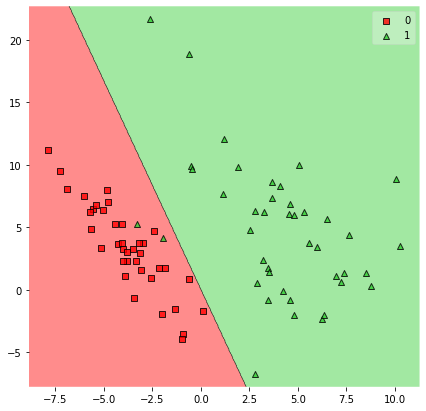

In [33]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN1, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Попробуем теперь реализовать другие виды нелинейности, раз сигмоида обладает таким неприятным эффектом. Начнем с Relu.

In [34]:
class Relu:
    """Rectified Linear Unit
    
    Параметры lr и debug - заглушки, чтобы из класса Network можно было циклически вызывать backward для 
    всех слоев с одним и тем же набором параметров. 
    """
    
    def __init__(self):
        self.X_ = None
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, 0, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * np.where(self.X_ <= 0, 0, 1)

Попробуем собрать простую нейросеть из трех слоев с нелинейностями Relu

In [35]:
NN3 = Network_no_sig([Linear(2, 10), Relu(), Linear(10, 10), Relu(), Linear(10, 1)])
train_network_no_sig(NN3, train_X, train_Y, lr = 0.03, max_iter = 300, debug = 1)

iteration 0, loss = 1.1539803072810173, accuracy = 0.2375
iteration 10, loss = 0.9476731292903423, accuracy = 0.8125
iteration 20, loss = 0.8051289241760969, accuracy = 0.8625
iteration 30, loss = 0.6057942766696215, accuracy = 0.925
iteration 40, loss = 0.42639840985648336, accuracy = 0.95
iteration 50, loss = 0.32721524647204203, accuracy = 0.9625
iteration 60, loss = 0.279081929064705, accuracy = 0.9625
iteration 70, loss = 0.23418874343478818, accuracy = 0.9625
iteration 80, loss = 0.2155600314352341, accuracy = 0.9625
iteration 90, loss = 0.20139648751091954, accuracy = 0.9625
iteration 100, loss = 0.18960667728363206, accuracy = 0.9625
iteration 110, loss = 0.1736273632362554, accuracy = 0.9625
iteration 120, loss = 0.16493975884119436, accuracy = 0.975
iteration 130, loss = 0.1606687674197218, accuracy = 0.9625
iteration 140, loss = 0.1551400996679419, accuracy = 0.975
iteration 150, loss = 0.152218043065011, accuracy = 0.975
iteration 160, loss = 0.16481961864497166, accuracy =

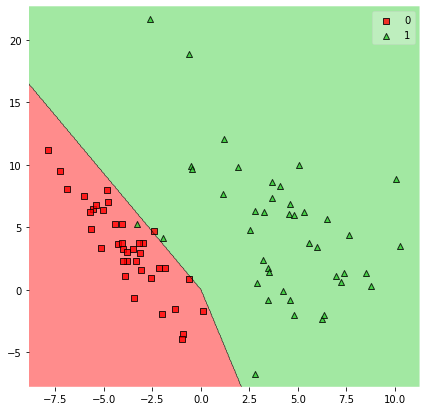

In [36]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN3, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Интересно, что разделяющая поверхность кусочно-линейна. Вряд ли это объясняется датасетом, но проверим на make_moons? которые точно нельзя разделить двумя отрезками:

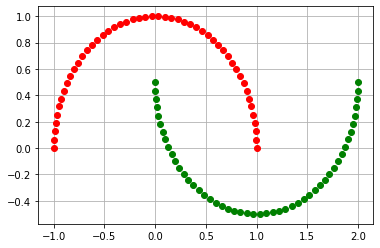

In [37]:
from sklearn.datasets import make_circles, make_moons
train_X_m, train_Y_m = make_moons()
plt.plot(train_X_m[np.where(train_Y_m==0), 0], train_X_m[np.where(train_Y_m==0), 1], 'ro')
plt.plot(train_X_m[np.where(train_Y_m==1), 0], train_X_m[np.where(train_Y_m==1), 1], 'go')
plt.grid()
plt.show()

In [38]:
NN4 = Network_no_sig([Linear(2, 10), Relu(), Linear(10, 10), Relu(), Linear(10, 1)])
train_network_no_sig(NN4, train_X_m, train_Y_m, lr = 0.01, max_iter = 20000, debug = 1)

iteration 0, loss = 1.0121672922372817, accuracy = 0.32
iteration 667, loss = 0.7248171877861023, accuracy = 0.83
iteration 1334, loss = 0.3996711096540093, accuracy = 0.87
iteration 2001, loss = 0.3653907489962876, accuracy = 0.86
iteration 2668, loss = 0.34647744891233745, accuracy = 0.87
iteration 3335, loss = 0.3350277052097954, accuracy = 0.87
iteration 4002, loss = 0.3269761589565314, accuracy = 0.87
iteration 4669, loss = 0.3213977550587151, accuracy = 0.87
iteration 5336, loss = 0.3225722274580039, accuracy = 0.87
iteration 6003, loss = 0.31503871384309606, accuracy = 0.86
iteration 6670, loss = 0.3167169552401174, accuracy = 0.86
iteration 7337, loss = 0.31126974073820746, accuracy = 0.87
iteration 8004, loss = 0.3115611253550742, accuracy = 0.86
iteration 8671, loss = 0.3102742616302567, accuracy = 0.86
iteration 9338, loss = 0.30771922291605736, accuracy = 0.87
iteration 10005, loss = 0.314544180900848, accuracy = 0.86
iteration 10672, loss = 0.3122833298133628, accuracy = 0

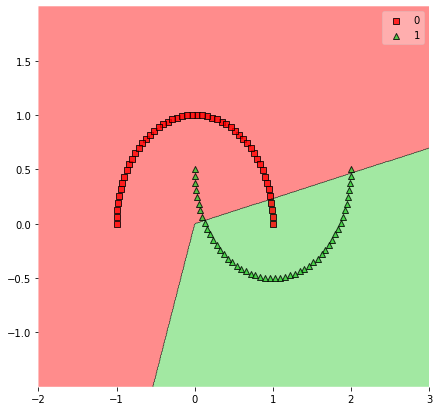

In [39]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X_m, train_Y_m, NN4, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Да, видим такую же картину. По какой-то причине сеть строит разделяющую поверхность из двух отрезков. Проверим, будет ли наблюдаться аналогичное поведение на другой нелинейности, например, на гиперболическом тангенсе:

In [40]:
class Tanh:
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        return upstream_grad * (1 - self.out ** 2)

In [62]:
NN4_tanh = Network_no_sig([Linear(2, 10), Tanh(), Linear(10, 10), Tanh(), Linear(10, 1)])
train_network_no_sig(NN4_tanh, train_X_m, train_Y_m, lr = 0.1, max_iter = 20000, debug = 1)

iteration 0, loss = 1.0042308259010315, accuracy = 0.41
iteration 667, loss = 0.41464742355048656, accuracy = 0.86
iteration 1334, loss = 0.39761906301602723, accuracy = 0.88
iteration 2001, loss = 0.37117033459246157, accuracy = 0.87
iteration 2668, loss = 0.3236787004338112, accuracy = 0.85
iteration 3335, loss = 0.14922366874961882, accuracy = 0.97
iteration 4002, loss = 0.0545386230749682, accuracy = 0.99
iteration 4669, loss = 0.06511021150739907, accuracy = 0.98
iteration 5336, loss = 0.04234175656749699, accuracy = 0.99
iteration 6003, loss = 0.0661828377428435, accuracy = 0.98
iteration 6670, loss = 0.044913382655662415, accuracy = 0.99
iteration 7337, loss = 0.029876107311235103, accuracy = 0.99
iteration 8004, loss = 0.05788106485494247, accuracy = 0.98
iteration 8671, loss = 0.033615162056035784, accuracy = 0.99
iteration 9338, loss = 0.06819365528405562, accuracy = 0.98
iteration 10005, loss = 0.02720843497766964, accuracy = 0.99
iteration 10672, loss = 0.03967931401232874,

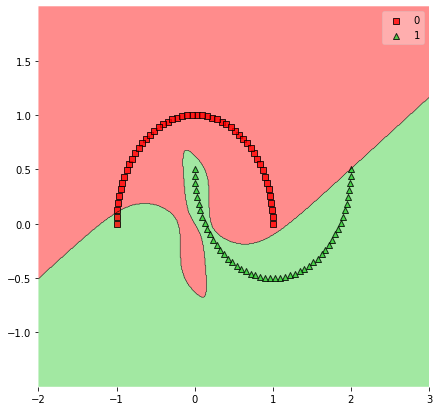

In [63]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X_m, train_Y_m, NN4_tanh, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Для гиперболического тангенса криволинейная разделяющая поверхность строится успешно при аналогичных параметрах нейросети. Возможно, с Relu получится добиться нужного результата, если от одного выхода перейти к двум. Для этого придется изменить функцию потерь, теперь она должна принимать ответы по каждому классу в отдельные входы. Чтобы добиться такого эффекта, последним слоем нейросети должен быть слой Softmax.

#### Softmax и Cross-Entropy Loss

Сначала придется изменить функцию потерь. Так как классов теперь может быть много, интересующая нас функция - Cross-Entropy Loss. Кросс-энтропия или перекрестная энтропия - это мера, показывающая различие между двумя распределениями. Коротко, как работает энтропия, и что такое перекрестная энтропия:

Допустим, есть дискретное распределение А, которое показывает, с какой вероятностью можно получить классы 1, 2, 3 и 4 из этого распределения. Если мы хотим закодировать сообщение, получающееся из этого распределения, например, 1,1,2,1,3,4,1 с помощью бинарного кода, то можно пойти двумя путями. Можно назначить каждому из классов двухбитовый код 00, 01, 10, 11 и кодировать каждый символ двухбитовым кодом. Другим путем будет использование префиксного кода, когда наиболее часто встречающемуся классу назначается более короткий код, а наиболее редко встречающемуся - более длинный. Если вероятность получить из распределения класс 1 равна 0.5, класс 2 - 0.25, а классы 3 и 4 - по 0.125 каждый, то очевидно, что наиболее короткий код мы должны назначить классу 1, более длинный - классу 2 и так далее. Если мы назначим классу 1 код 0, все остальные коды, начинающиеся с 0, будут недоступны, так как мы вынуждены использовать коды переменной длины, при этом никакого "стоп-слова" для обозначения окончания конца кода мы не используем. Эта ситуация называется префиксное свойство, а коды, которые этим свойством обладают - префиксные коды. Соответственно, классу 2 мы назначаем код 10, классу 3 - 110, классу 4 - 111. Чем короче код, тем больше его "стоимость" в смысле отъедаемого пространства кодов. Например, если мы занимаем код 10, то мы не сможем больше использовать 1/4 часть всего адресного пространства. Стоимость кода легко определить: если длина кодового слова равна L, 
#### $$Стоимость = \frac{1}{2^{L}}$$
Из стоимости можно посчитать длину кодового слова, которое она дает:
#### $$L = log_2(\frac{1}{Стоимость})$$

**Энтропия распределения** - это сумма произведений вероятности появления класса и длины назначенного ему кодового слова, взятая по всем классам. Фактически, эта сумма определяет минимальную среднюю длину кодового слова, которая требуется для оптимального кодирования распределения.
#### $$Entropy = \sum_i p(i)L(i)$$
Доказано, что для получения оптимального кода распределять стоимости кодовых слов нужно так, как распределены вероятности появления этих слов в распределении. Соответственно, формулу для энтропии распределения можно переписать:
#### $$Entropy = \sum_i p(i)log_2(\frac{1}{p(i)}) = -\sum_i p(i)log_2(p(i))$$

**Перекрестная энтропия** двух распределений определяется как минимальная средняя длина кодового слова, если сообщения, полученные из одного распределения, кодировать оптимальным кодом из другого распределения. Если есть распределения A и B, то кросс-энтропия это
#### $$CE = -\sum_ip_A(i)log_2(p_B(i))$$
В нашем случае мы хотим сравнивать распределение, получившееся в результате работы классификатора, и "истинное" распределение, которое дают ответы на обучающей выборке:
#### $$CE = -\sum_ip_{Ytrue}(i)log_2(p_{\hat Y}(i))$$
Так как распределение YTrue показывает, какой именно класс является истинным для данного экземпляра, по всем "неистинным" классам для данного экземпляра вероятности будут равны 0, а для единственного "истинного" класса - единице. Соответственно, все слагаемые в сумме, которые являются сомножителями с вероятностями "неистинных" классов, обращаются в ноль, и формула упрощается:
#### $$CE = -1 \cdot log_2(p_{\hat Y}(i))$$
То есть, кросс-энтропия между распределением на выходе модели и истинным распределением обучающей выборки равна оценке вероятности для истинного класса на выходе модели по каждому экземпляру выборки.

Производная перекрестной энтропии легко вычисляется по формуле производной логарифма:
#### $$\frac{\partial CE}{\partial p(i)} = \frac{-1}{ln(2)p(i)}$$
Если на вход CELoss подается batch размером N, и количество классов в обучающей выборке равно T, то градиентом функции будет матрица (N x T), где в каждой строке будут нули во всех позициях, за исключением истинного класса.

In [43]:
def CELoss(Y_true, Y_hat):
    """ Функция потерь Перекрестная кросс-энтропия (Cross-Entropy Loss)
    
    
    Параметры:
    Y_true -- ответы обучающей выборки. Матрица размерностью (N, T), где N - размер batch, T - количество классов в датасете, значения 0 или 1
    Y_hat -- ответы модели. Матрица размерностью (N, T), где N - размер batch, T - количество классов в датасете.
    Значения - вероятности классов в интервале [0, 1]
    
    Возвращает усредненное по batch значение потерь, а также матрицу градиентов размерностью (N, T) для использования в backpropagation
    
    """
    
    eps = 1e-10
    Y_loss = -np.log2(Y_hat + eps)
    Y_grad = -1 / (np.log(2) * Y_hat + eps)
    loss = Y_loss * Y_true
    grad = Y_grad * Y_true
    return loss.sum(), grad

Помимо изменения функции потерь, необходимо научить нейросеть выдавать ответы в отдельные выходы по числу классов, каждый из которых будет содержать вероятность соответствующего класса. Для этого последним слоем нейросети необходимо установить Softmax.

**Softmax** - функция, преобразующая вектор, содержащий произвольные действительные числа, в вектор такой же размерности, содержащий числа из интервала (0, 1), суммирующиеся в единицу:
#### $$Softmax(a) = \frac{e^{a_i}}{\sum_je^{a_j}}$$
, где $a_i$, $a_j$ - компоненты вектора a.
Функция Softmax векторная - она принимает на вход вектор логитов от линейного слоя и передает на выход вектор вероятностей по классам. Так как функция участвует backpropagation, необходимо рассчитать ее частную производную по каждому входу. Так как каждый вход оказывает влияние на каждый выход через сумму в знаменателе, частные производные по входам должны рассчитываться через матрицу Якоби. Производная по входам считается по правилу производной отношения функций, здесь приведем якобиан без вывода. Если выходы слоя Softmax равны $[S_1, S_2, ...S_N]$, то якобиан - это матрица (N x N), значения которой рассчитываются по формуле

#### $$Jacobian(SM) = \begin{pmatrix} S_1(1 - S_1)&-S_1S_2&. . .&-S_1S_N\\...&...&...&...\\-S_NS_1&-S_NS_2&. . .&S_N(1 - S_N)\end{pmatrix}$$
Напишем отдельную функцию для создания якобиана, ей удобно будет пользоваться при расчете градиентов внутри слоя Softmax

In [44]:
def create_sm_jacobian(sm_out):
    """ Фуункция расчета якобиана для Softmax
    
    
    Параметры:
    
    sm_out -- сохраненный на этапе forward pass выход из слоя Softmax. Вектор размерности (количество классов, 1)
    Если через Softmax проходил batch размером (N x количество классов), каждая строка этой матрицы должна подаваться на вход функции отдельно
    
    Возвращает якобиан размерности (количество классов x количество классов)
    """
    
    
    jac = np.zeros((sm_out.shape[0], sm_out.shape[0]))
    for i in range(sm_out.shape[0]):
        for j in range(sm_out.shape[0]):
            if i == j:
                jac[i, j] = sm_out[i] * (1 - sm_out[i])
            else:
                jac[i, j] = -1 * sm_out[i] * sm_out[j]
    return jac

Forward pass Softmax довольно прост. Матрица размером N экземпляров x T классов подается на вход, по строкам матрицы рассчитываются суммы экспонент, каждый элемент матрицы делится на сумму строки.

Backward pass сложнее. Так как каждый экземпляр класса, подаваемый на вход, порождает T выходов Softmax, по каждому такому экземпляру должен рассчитываться отдельный якобиан. Соответственно, для batch размером N в слое Softmax на backward pass должны быть рассчитаны градиенты размерности (N x T x T) - N квадратных TxT якобианов. Для расчета нисходящих градиентов по формуле производной сложной функции необходимо входящую матрицу градиентов от функции потерь размерности (N x T) скалярно перемножить с якобианами:
#### $$\frac{\partial Loss(Y)}{\partial Y} = \frac{\partial Loss(SM(Y))}{\partial SM(Y)} \cdot \frac{\partial SM(Y)}{\partial Y}$$
, где Y - матрица входных сигналов в слой Softmax.

Однако мы не можем скалярно перемножать матрицы размерностей (N x T) и (N x T x T). Поэтому придется делать это построчно: для каждой строки входящего градиента формировать из строки сохраненных на этапе forward pass выходов якобиан и рассчитывать их скалярное произведение. Результат такого произведения - матрица размером (T, 1) - одна строка входящих градиентов для линейного слоя, следующего за Softmax. Пройдя циклом по всем якобианам Softmax и рассчитывая такие скалярные произведения, из получающихся строк градиентов будет сформирована итоговая матрица градиентов размерности (N, T)

In [45]:
class Softmax:
    """ Слой Softmax
    Реализация написана для batch_size >= 2
    
    На основе сохраненных на forward pass значений выходов формирует на backward pass якобианы частных производных выходов по входам с помощью create_sm_jacobian(). 
    Так как N таких якобианов формируют матрицу размером N x количество классов x количество классов, 
    скалярное произведение такой матрицы на входящие градиенты может быть получено только попарно - одна строка входящего градиента на 
    один якобиан.
    """
    
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        exps = np.exp(X)
        sum_col = np.reshape(np.sum(exps, axis = 1), (-1, 1))
        sums = sum_col
        for i in range(X.shape[1] - 1):
            sums = np.concatenate((sums, sum_col), axis = 1)
        self.out = exps / sums
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        gradients = np.array([])
        for ug, sm_out in zip(upstream_grad, self.out):
            SMJ = create_sm_jacobian(sm_out)
            grad = np.dot(ug, SMJ)
            gradients = np.append(gradients, grad)
        return np.reshape(gradients, (upstream_grad.shape[0], -1))

Ввиду того, что на выходе нейросети теперь N сигналов от N нейронов, и выбирать необходимо нейрон, отдающий максимальную вероятность класса, перепишем метод predict:

In [46]:
class Network_multiclass:
    
    """Аналогичен классу Network, но метод predict переписан с учетом наличия Softmax на выходе из нейросети"""
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = self.forward(X).argmax(axis = 1)
        return Y_hat

Для расчета потерь в функцию Cross-Entropy Loss ответы из обучающей выборки необходимо подавать в виде one-hot encoded вектора:

In [47]:
def one_hot_enc(vec, num_classes):
    
    """Преобразует вектор скаляров - номеров классов в матрицу one-hot-encoded векторов"""
    
    assert len(vec.shape) == 2 and vec.shape[1] == 1, 'only [N x 1] vectors are supported'
    
    result = np.zeros((vec.shape[0], num_classes))
    np.put_along_axis(result, vec, 1, axis = 1)
    return result

In [48]:
def train_network_multiclass(Net, X_train, Y_train, batch_size = 8, lr = 1, max_iter = 50, debug = 0):
    
    """Функция аналогична train_network(), но переписана с учетом Softmax на выходе из сети. Используется функция потерь CELoss,
    также ввиду векторного вида ответов изменен метод расчета accuracy"""
    
    loss = 1e3
    iteration = 0
    Y_train_enc = one_hot_enc(np.reshape(Y_train, (-1, 1)), 2)
    
    while loss > 0.01 and iteration < max_iter:
        
        Y_hat = Net.forward(X_train)
        loss, _ = CELoss(Y_train_enc, Y_hat)
        acc = np.where(Y_train == Y_hat.argmax(axis = 1))[0].shape[0] / len(Y_train)
        
        period = math.ceil(max_iter / 30)
        if debug and iteration % period == 0: print(f'iteration {iteration}, loss = {loss}, accuracy = {acc}')
        
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = CELoss(Y_train_enc[batch_index], Y_hat)
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

Создадим сеть с Relu и двумя выходами:

In [49]:
NNM = Network_multiclass([Linear(2, 20), Relu(), Linear(20, 20), Relu(), Linear(20, 2), Softmax()])
train_network_multiclass(NNM, train_X, train_Y, lr = 0.03, max_iter = 500, debug = 1)

iteration 0, loss = 141.95702904462814, accuracy = 0.0625
iteration 17, loss = 24.410353317158297, accuracy = 0.9375
iteration 34, loss = 17.306033525572275, accuracy = 0.9375
iteration 51, loss = 14.520391354055391, accuracy = 0.9625
iteration 68, loss = 12.987942054761106, accuracy = 0.9625
iteration 85, loss = 11.93989279873756, accuracy = 0.9625
iteration 102, loss = 10.769380307633924, accuracy = 0.9625
iteration 119, loss = 10.37125744636461, accuracy = 0.9625
iteration 136, loss = 9.824887598647592, accuracy = 0.9625
iteration 153, loss = 10.302598055358565, accuracy = 0.9625
iteration 170, loss = 7.774043113340291, accuracy = 0.975
iteration 187, loss = 9.459360539130046, accuracy = 0.975
iteration 204, loss = 10.986717350161172, accuracy = 0.975
iteration 221, loss = 7.910080326911654, accuracy = 0.975
iteration 238, loss = 7.152915027484738, accuracy = 0.975
iteration 255, loss = 7.086373070201795, accuracy = 0.975
iteration 272, loss = 7.989916781443412, accuracy = 0.975
ite

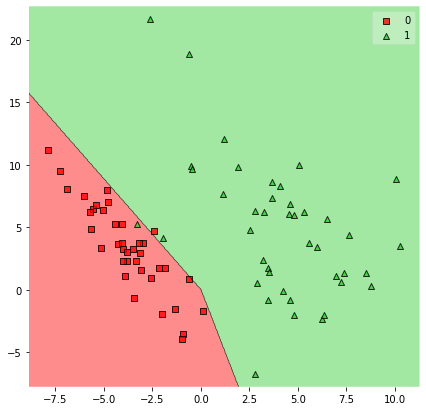

In [50]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NNM, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [51]:
NNM = Network_multiclass([Linear(2, 20), Relu(), Linear(20, 20), Relu(), Linear(20, 2), Softmax()])
train_network_multiclass(NNM, train_X_m, train_Y_m, lr = 0.01, max_iter = 15000, debug = 1)

iteration 0, loss = 106.93529403209686, accuracy = 0.49
iteration 500, loss = 45.01806008070707, accuracy = 0.86
iteration 1000, loss = 36.4636442521587, accuracy = 0.88
iteration 1500, loss = 35.0317420642823, accuracy = 0.87
iteration 2000, loss = 33.78243998833932, accuracy = 0.87
iteration 2500, loss = 33.15201418357901, accuracy = 0.87
iteration 3000, loss = 32.60948888794519, accuracy = 0.87
iteration 3500, loss = 32.29414271330461, accuracy = 0.87
iteration 4000, loss = 32.00310511200223, accuracy = 0.86
iteration 4500, loss = 31.772661745897494, accuracy = 0.86
iteration 5000, loss = 31.526998180081137, accuracy = 0.88
iteration 5500, loss = 31.9890539906919, accuracy = 0.86
iteration 6000, loss = 31.07489910442382, accuracy = 0.87
iteration 6500, loss = 30.9435038206866, accuracy = 0.86
iteration 7000, loss = 30.775053388962988, accuracy = 0.87
iteration 7500, loss = 31.088390888937283, accuracy = 0.86
iteration 8000, loss = 30.92381310876226, accuracy = 0.86
iteration 8500, l

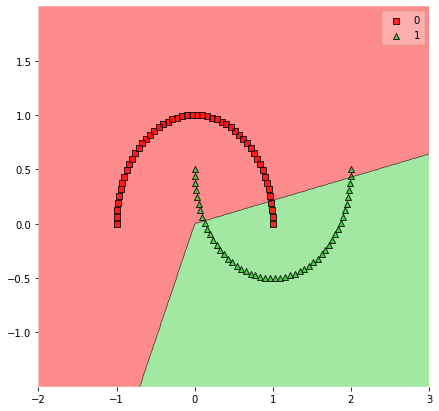

In [52]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X_m, train_Y_m, NNM, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Разделяющая поверхность снова кусочно-линейная. Возможно, как-то сказывается то, что Relu срезает все градиенты в отрицательной зоне. Попробуем LeakyRelu, которая работает и в отрицательной зоне, передавая входной сигнал, домноженный на коэффициент $\alpha $

In [53]:
class LeakyRelu:
    
    """Нелинейность, аналогичная Relu, но также передающая и сигналы в отрицательной зоне с коэффициентом alpha"""
    
    def __init__(self, alpha):
        self.X_ = None
        self.alpha = alpha
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, X * self.alpha, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * np.where(self.X_ <= 0, self.alpha, 1)

In [54]:
NNM = Network_multiclass([Linear(2, 20), LeakyRelu(0.1), Linear(20, 20), LeakyRelu(0.1), Linear(20, 2), Softmax()])
train_network_multiclass(NNM, train_X_m, train_Y_m, lr = 0.01, max_iter = 15000, debug = 1)

iteration 0, loss = 99.8208082318306, accuracy = 0.6
iteration 500, loss = 52.780934140086174, accuracy = 0.84
iteration 1000, loss = 39.10290249064565, accuracy = 0.86
iteration 1500, loss = 36.391583075746894, accuracy = 0.88
iteration 2000, loss = 35.47221154905856, accuracy = 0.86
iteration 2500, loss = 34.062676578294486, accuracy = 0.88
iteration 3000, loss = 33.51999180554412, accuracy = 0.87
iteration 3500, loss = 33.6096963477321, accuracy = 0.86
iteration 4000, loss = 32.741482665296644, accuracy = 0.87
iteration 4500, loss = 32.65187980909832, accuracy = 0.87
iteration 5000, loss = 32.26872366794851, accuracy = 0.87
iteration 5500, loss = 32.00173222180456, accuracy = 0.87
iteration 6000, loss = 32.380714797531255, accuracy = 0.87
iteration 6500, loss = 31.905237209633924, accuracy = 0.87
iteration 7000, loss = 31.462826856644824, accuracy = 0.86
iteration 7500, loss = 31.483528541459236, accuracy = 0.87
iteration 8000, loss = 31.039723799505737, accuracy = 0.87
iteration 85

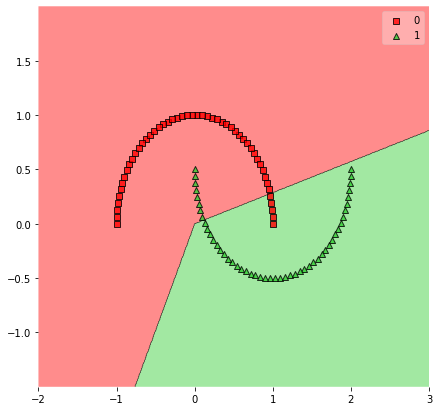

In [55]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X_m, train_Y_m, NNM, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Также без изменений. Попробуем Tanh и сигмоиду на сети с Softmax и CELoss

In [56]:
NNM_tanh = Network_multiclass([Linear(2, 20), Tanh(), Linear(20, 20), Tanh(), Linear(20, 2), Softmax()])
train_network_multiclass(NNM_tanh, train_X_m, train_Y_m, lr = 0.07, max_iter = 15000, debug = 1)

iteration 0, loss = 108.70589351654053, accuracy = 0.18
iteration 500, loss = 42.65426101908088, accuracy = 0.86
iteration 1000, loss = 39.64517963118851, accuracy = 0.87
iteration 1500, loss = 36.898490181192756, accuracy = 0.87
iteration 2000, loss = 32.32973763067275, accuracy = 0.87
iteration 2500, loss = 27.7547127060825, accuracy = 0.86
iteration 3000, loss = 24.98855602867843, accuracy = 0.91
iteration 3500, loss = 11.884444020653973, accuracy = 0.98
iteration 4000, loss = 10.175400323161284, accuracy = 0.98
iteration 4500, loss = 8.703182892131963, accuracy = 0.98
iteration 5000, loss = 6.143860024543358, accuracy = 0.98
iteration 5500, loss = 4.889913719164504, accuracy = 0.99
iteration 6000, loss = 3.7827317291092513, accuracy = 0.99
iteration 6500, loss = 6.21369867714818, accuracy = 0.98
iteration 7000, loss = 5.772394724386707, accuracy = 0.98
iteration 7500, loss = 3.3913742719038495, accuracy = 0.99
iteration 8000, loss = 3.733361529947153, accuracy = 0.99
iteration 8500

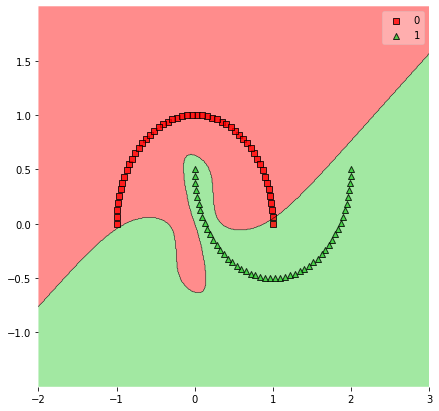

In [57]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X_m, train_Y_m, NNM_tanh, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [58]:
NNM_sig = Network_multiclass([Linear(2, 20), Sigmoid(), Linear(20, 20), Sigmoid(), Linear(20, 2), Softmax()])
train_network_multiclass(NNM_sig, train_X_m, train_Y_m, lr = 0.07, max_iter = 20000, debug = 1)

iteration 0, loss = 114.68418195843697, accuracy = 0.5
iteration 667, loss = 45.49668487906456, accuracy = 0.84
iteration 1334, loss = 38.73194572981447, accuracy = 0.87
iteration 2001, loss = 38.84754993766546, accuracy = 0.88
iteration 2668, loss = 40.32208377914503, accuracy = 0.87
iteration 3335, loss = 40.43288873927668, accuracy = 0.87
iteration 4002, loss = 38.085399059578776, accuracy = 0.88
iteration 4669, loss = 39.85703979805112, accuracy = 0.87
iteration 5336, loss = 38.84501355886459, accuracy = 0.87
iteration 6003, loss = 37.53046210389584, accuracy = 0.88
iteration 6670, loss = 37.519201069138944, accuracy = 0.89
iteration 7337, loss = 39.23905076738447, accuracy = 0.88
iteration 8004, loss = 36.85368508845568, accuracy = 0.88
iteration 8671, loss = 36.148095808923244, accuracy = 0.87
iteration 9338, loss = 37.095570038072765, accuracy = 0.89
iteration 10005, loss = 34.925883864983916, accuracy = 0.89
iteration 10672, loss = 33.26381348958239, accuracy = 0.88
iteration 1

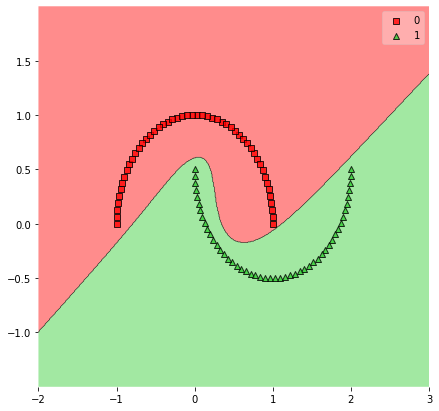

In [59]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X_m, train_Y_m, NNM_sig, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Неожиданный вывод по результатам испытаний - как Relu, так и LeakyRelu, успешно работая на крупных сверточных сетях, по какой-то причине не отрабатывают на неглубоких сетях и формируют кусочно-линейную разделяющую поверхность. Вопрос требует дополнительного исследования. 